In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keralapolitics/Kerala political comments.csv


In [2]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import confusion_matrix


In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Get English stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    preprocessed_text = ' '.join(filtered_tokens)  # Join tokens back into a string
    return preprocessed_text

In [5]:
# Load data
data = pd.read_csv(r"/kaggle/input/keralapolitics/Kerala political comments.csv",encoding="latin")

data['tweets'] = data['tweets'].apply(preprocess_text)


In [6]:
data.target.value_counts()

target
0    1360
1    1128
Name: count, dtype: int64

In [7]:
data.shape

(2488, 2)

In [9]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [10]:
#!pip install --upgrade transformers



In [11]:
# Initialize tokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
# Define CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.tweets.values
        self.targets = self.data.target.values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Define Encoder-Decoder model
class EncoderDecoder(nn.Module):
    def __init__(self, num_layers, pretrained_model_name, num_classes, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.encoders = nn.ModuleList([RobertaModel.from_pretrained(pretrained_model_name) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([SentimentDecoder(self.encoders[i].config.hidden_size, hidden_size, num_classes)
                                        for i in range(num_layers)])
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        pooled_outputs = []
        for encoder in self.encoders:
            output = encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            pooled_outputs.append(output.pooler_output)
        pooled_output = torch.cat(pooled_outputs, dim=1)  # Concatenate pooled outputs from all encoders
        pooled_output = self.drop(pooled_output)  # Apply dropout
        decoder_outputs = []
        for decoder in self.decoders:
            output, _ = decoder(pooled_output.unsqueeze(0), None)  # Pass pooled_output through each decoder
            decoder_outputs.append(output)
        return torch.stack(decoder_outputs).mean(dim=0)  # Average the decoder outputs from all layers


In [13]:
class SentimentDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = torch.log_softmax(self.out(output[0]), dim=1)
        return output, hidden

class StackedTransformer(nn.Module):
    def __init__(self, num_layers, pretrained_model_name, num_classes, hidden_size):
        super(StackedTransformer, self).__init__()
        self.num_layers = num_layers
        self.encoders = nn.ModuleList([RobertaModel.from_pretrained(pretrained_model_name) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([SentimentDecoder(self.encoders[0].config.hidden_size, hidden_size, num_classes) for _ in range(num_layers)])
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        encoder_outputs = []
        for encoder in self.encoders:
            encoder_output = encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            encoder_outputs.append(encoder_output.pooler_output)
        stacked_encoder_output = torch.stack(encoder_outputs, dim=1)
        
        decoder_outputs = []
        for decoder, encoder_output in zip(self.decoders, stacked_encoder_output.unbind(dim=1)):
            pooled_output = self.drop(encoder_output)
            decoder_output, _ = decoder(pooled_output.unsqueeze(0), None)
            decoder_outputs.append(decoder_output)
        stacked_decoder_output = torch.stack(decoder_outputs, dim=1)
        
        # Combine decoder outputs, e.g., by averaging or concatenation
        final_output = torch.mean(stacked_decoder_output, dim=1)
        
        return final_output.squeeze(0)


In [14]:
# Training parameters
MAX_LEN = 128
BATCH_SIZE = 16
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
EPOCHS = 30
NUM_LAYERS = 4  # Number of encoder-decoder pairs
HIDDEN_SIZE = 512  # Hidden size of each decoder


In [15]:
# Usage
model = StackedTransformer(num_layers=4, pretrained_model_name='roberta-base', num_classes=NUM_CLASSES, hidden_size=512)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['robert

In [16]:
# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [17]:

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:

# Create train and test datasets
train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
epoch_nums = []
train_losses = []
train_accuracies = []


In [20]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    epoch_nums.append(epoch + 1)
    train_losses.append(avg_epoch_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy}')


Epoch 1/30, Loss: 0.6221301155090332, Accuracy: 0.6241206030150753
Epoch 2/30, Loss: 0.4607530025243759, Accuracy: 0.7939698492462312
Epoch 3/30, Loss: 0.3561250175535679, Accuracy: 0.849748743718593
Epoch 6/30, Loss: 0.16357134295254946, Accuracy: 0.9407035175879397
Epoch 7/30, Loss: 0.11629662753269077, Accuracy: 0.9613065326633166
Epoch 8/30, Loss: 0.121107208147645, Accuracy: 0.9613065326633166
Epoch 9/30, Loss: 0.08039456480741501, Accuracy: 0.9743718592964824
Epoch 10/30, Loss: 0.08831489340215921, Accuracy: 0.9708542713567839
Epoch 11/30, Loss: 0.03816677809506655, Accuracy: 0.9894472361809046
Epoch 12/30, Loss: 0.0277291541332379, Accuracy: 0.9914572864321608
Epoch 13/30, Loss: 0.02634260073164478, Accuracy: 0.9919597989949749
Epoch 14/30, Loss: 0.019201384963002055, Accuracy: 0.9949748743718593
Epoch 15/30, Loss: 0.01517071727057919, Accuracy: 0.9954773869346734
Epoch 16/30, Loss: 0.013378056138753891, Accuracy: 0.9969849246231156
Epoch 17/30, Loss: 0.012846535394433886, Accur

In [21]:
# Evaluation
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device, dtype=torch.long)

        outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())



        # Ensure outputs have the expected shape
        if outputs.dim() == 1:
            # Handle the case where outputs might be a single-dimension tensor
            outputs = outputs.unsqueeze(0)  # Add a batch dimension if needed
        
        if outputs.dim() == 2:
            _, predicted = torch.max(outputs, 1)
        else:
            raise ValueError(f'Unexpected output shape: {outputs.shape}')

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    
# Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8012048192771084
Confusion Matrix:
[[233  48]
 [ 51 166]]


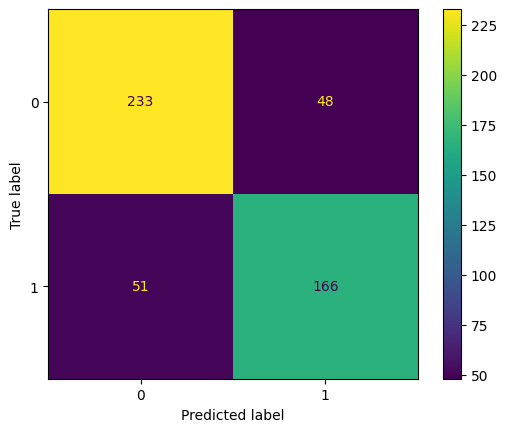

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt


# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


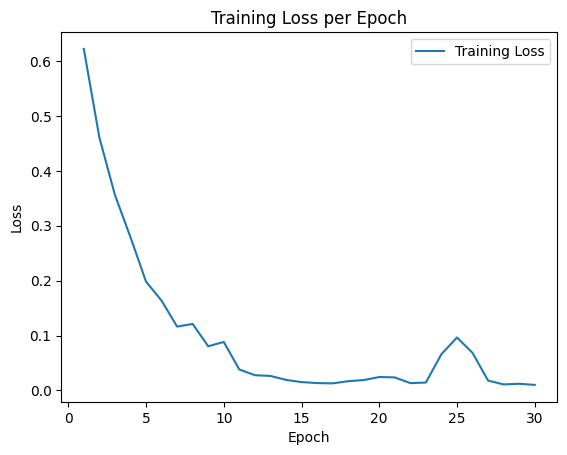

In [23]:
import matplotlib.pyplot as plt

# Plot the epoch and training loss
plt.plot(epoch_nums, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

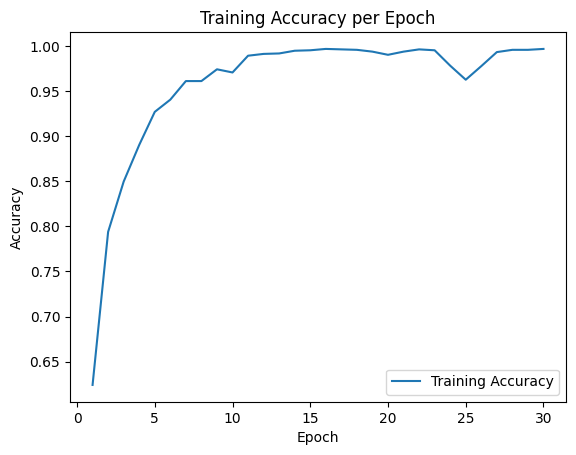

In [24]:

# Plot the training accuracy curve
plt.plot(epoch_nums, train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()

In [25]:
# Prediction function remains the same
def predict_sentiment(text, model, tokenizer, max_len):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        input_ids = torch.tensor(inputs['input_ids']).unsqueeze(0).to(device)
        attention_mask = torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"]).unsqueeze(0).to(device)
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        # Reshape outputs tensor
        outputs = outputs.view(1, -1)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_index = torch.max(probabilities, 1)
        predicted_label = "Positive" if predicted_index.item() == 1 else "Negative"
        return predicted_label


new_text = ["You have to go down to the hamlets without your entourage, hey. We'll show you... Many people who are in poverty... Not from now on, but for a long time... People have a vote bank. Come up with a rule that those above the age of 50 should not be made ministers. There are many knowledgeable and educated young people in Kerala who are capable of holding the wheel of governance... There is no need for any political legacy... We'll rule and show you. A poverty-free, waste-free Kerala. It's like it's got alfaham in Koren's hand now...A multi fungal virus in Kerala Poli- Trics...",
    "What is that Plan B, sir? Let the surprise come out, sir. Are you going to shave off everything you've taken away and leave the country? Or is it to be declared a bankrupt? Or is it that al-Kerala will establish the kingdom? With all this in mind, the NIA is building a massive office in Kochi. If there is a raid that started in Kochi today, it is the first step to demolish this Plan B... Beware...",
    "The people who witnessed the incident told the truth, so others understand that he was innocent.",
    "It was no longer possible to get the officials to work because they were made to extort money from the locals.",
    "Even if it's not a new Kerala anymore, it's not 10 Kerala audiences, but you see that I was beaten up and thrown out, including myself, who had voted long ago.",
    "Her party has threatened and extorted money from many companies",
    "BJP is a communal party",
    "Everyone points finger at Rahul Gandhi, but not at the people who are in power",
    "Is this the right news? Will BJP show such stupidity? I didn't see anything on any other channel.",
    "Hats off to Tharoor ji who came on time, created a stampede and came to win votes",
    "The very objective of the Sangh Parivar is to create communal riots across the country.......yet Satheesan and his gang don't understand!Babri Masjid has disappeared as a result of these people's silence! It is true that minorities should vote carefully when the election is near. Because if the Sunkis come to power, the country itself will be brought to Kavi! It will be dangerous! What the Chief Minister said is correct. What is the doubt about that.....",
    "Anil Antony, PC George, George Kurian, Alphonse Kannamthanam, Puppy George, are they all for or against it?Yesterday gujarat, haryana, up, mp, tripura, karnataka, delhi, today manipur, if they get a seat in kerala it will repeat in kerala too, think before you vote, the tragedy of the states described above is at the doorstep of keralakara, vote for udf to prevent that door from entering, palm the sign",
    "Shylaja teacher is a good person", "Now, towards the election negative impacts are happening from their side", "people are moving against her", "teacher provides confidence to people", "because of her presence and work the people of Kerala survive from covid",
    "Shylaja teacher is a good person, but now towards the election negative impacts are happening from their side people are moving against her. Teacher provides confidence to people. Because of her presence and work the people of Kerala survive from covid"]
predicted_sentiments = []
for tweet in new_text:
    predicted_sentiment = predict_sentiment(tweet, model, tokenizer, MAX_LEN)
    predicted_sentiments.append(predicted_sentiment)

for tweet, sentiment in zip(new_text, predicted_sentiments):
    print(f"{tweet}  :  {sentiment}\n")

You have to go down to the hamlets without your entourage, hey. We'll show you... Many people who are in poverty... Not from now on, but for a long time... People have a vote bank. Come up with a rule that those above the age of 50 should not be made ministers. There are many knowledgeable and educated young people in Kerala who are capable of holding the wheel of governance... There is no need for any political legacy... We'll rule and show you. A poverty-free, waste-free Kerala. It's like it's got alfaham in Koren's hand now...A multi fungal virus in Kerala Poli- Trics...  :  Positive

What is that Plan B, sir? Let the surprise come out, sir. Are you going to shave off everything you've taken away and leave the country? Or is it to be declared a bankrupt? Or is it that al-Kerala will establish the kingdom? With all this in mind, the NIA is building a massive office in Kochi. If there is a raid that started in Kochi today, it is the first step to demolish this Plan B... Beware...  :  